In [1]:
import cv2
import numpy as np
from numpy import unravel_index
import math
from matplotlib import pyplot as plt

sample1 = cv2.imread("hw2_sample_images/sample1.png", cv2.IMREAD_GRAYSCALE)
sample2 = cv2.imread("hw2_sample_images/sample2.png", cv2.IMREAD_GRAYSCALE)
sample3 = cv2.imread("hw2_sample_images/sample3.png", cv2.IMREAD_GRAYSCALE)
sample5 = cv2.imread("hw2_sample_images/sample5.png", cv2.IMREAD_GRAYSCALE)

In [2]:
def gauss(kernel_size, sigma):
    #定型0填充
    kernel = np.zeros((kernel_size, kernel_size))
    #確定正態分佈中間值
    center = kernel_size // 2
    # s:方差 sum:記錄總和
    s = sigma ** 2
    sum = 0
    for i in range(kernel_size):
        for j in range(kernel_size):
            #由於最後要進行歸一化處理，此處根號下2Π計算可以省略
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * s))
            sum += kernel[i, j]
    #歸一化處理後輸出
    kernel = kernel / sum
    return kernel

In [3]:
def convolve2d(img, kernel_filter): # in same place
    kernel_size = kernel_filter.shape[0]
    gap = kernel_size // 2
    pad_img = np.lib.pad(img,(gap,gap),'constant')
    height, width = pad_img.shape
    
    for i in range(gap, height - gap):
        for j in range(gap, width - gap):
            patch = pad_img[i-gap:i+gap+1,j-gap:j+gap+1] * kernel_filter
            pad_img[i][j] = patch.sum()

    return pad_img[gap:height-gap,gap:width-gap] # clip padding

In [3]:
np.lib.pad([[1,2],[3,4]],(3,3),'constant')

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0, 0],
       [0, 0, 0, 3, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

## Sobel edge detection

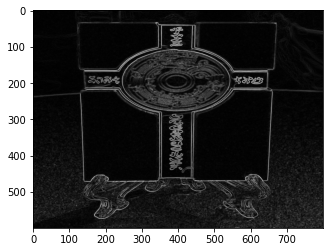

In [46]:
# 1st order edge detection
def sobel_gradient(img):
    K = 2 #Sobel

    row_filter = np.array([[-1, 0, 1], [-K, 0, K], [-1, 0, 1]])
    col_filter = np.array([[1, K, 1], [0, 0, 0], [-1, -K, -1]])
    kernel_size = 3
    
    gap = kernel_size // 2
    pad_img = np.lib.pad(img,(gap,gap),'reflect')
    height, width = pad_img.shape
    res = np.zeros((height, width), dtype = 'float32')

    
    for i in range(gap, height - gap):
        for j in range(gap, width - gap):
            patch = pad_img[i-gap:i+gap+1,j-gap:j+gap+1]
            row_gradient = row_filter * patch
            col_gradient = col_filter * patch
            gradient = math.sqrt(math.pow(row_gradient.sum(), 2) + math.pow(col_gradient.sum(), 2))
            res[i][j] = gradient
            
    return res[gap:height-gap,gap:width-gap]

result1 = sobel_gradient(sample1)
cv2.imwrite("result1.png",result1)
plt.imshow(result1, cmap='gray')

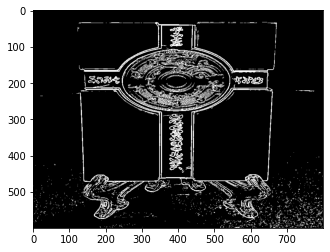

In [5]:
# threshold  
def sobel_threshold(img,threshold):
    res = img.copy()
    res[img > threshold] = 255
    res[img <= threshold] = 0
    return res
result2 = sobel_threshold(result1, 200)
plt.imshow(result2, cmap='gray')

## Canny edge detection

start Canny edge detection
    start noise_reduction


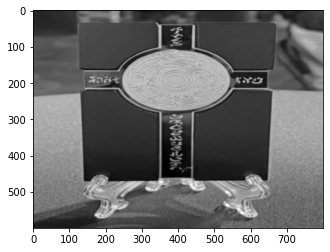

In [6]:
# Canny edge detection
print('start Canny edge detection')
def noise_reduction(img):
    print('    start noise_reduction')
    Gaussian_filter = np.array([[2, 4, 5, 4, 2], [4, 9, 12, 9, 4], [5, 12, 15, 12, 5], [4, 9, 12, 9, 4], [2, 4, 5, 4, 2]]) / 159
    return convolve2d(img, Gaussian_filter)

noise_reduction_sample1 = noise_reduction(sample1)
plt.imshow(noise_reduction_sample1, cmap='gray')

    start compute gradient magnitude and orientation


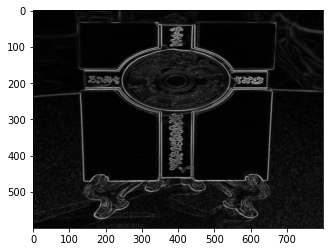

In [7]:
# compute gradient magnitude and orientation
def gradient_theta(img):
    print('    start compute gradient magnitude and orientation')
    
    K = 2 #Sobel

    row_filter = np.array([[-1, 0, 1], [-K, 0, K], [-1, 0, 1]])
    col_filter = np.array([[1, K, 1], [0, 0, 0], [-1, -K, -1]])
    kernel_size = 3
    
    gap = kernel_size // 2
    pad_img = np.lib.pad(img,(gap,gap),'reflect')
    height, width = pad_img.shape
    gradient_img = np.zeros((height, width), dtype = 'float32')
    theta = np.zeros((height, width), dtype = 'float32')

    
    for i in range(gap, height - gap):
        for j in range(gap, width - gap):
            patch = pad_img[i-gap:i+gap+1,j-gap:j+gap+1]
            row_magnitude = (patch * row_filter).sum()
            col_magnitude = (patch * col_filter).sum()
            
            theta[i][j] = np.arctan2(col_magnitude, row_magnitude)
            gradient_img[i][j] = np.hypot(row_magnitude, col_magnitude)
            
    gradient_img = (gradient_img / gradient_img.max()) * 255
    
    return gradient_img[gap:height-gap,gap:width-gap], theta[gap:height-gap,gap:width-gap]

gradient_sample1, theta_sample1 = gradient_theta(noise_reduction_sample1)
plt.imshow(gradient_sample1, cmap='gray')

    start Non-maximal suppression


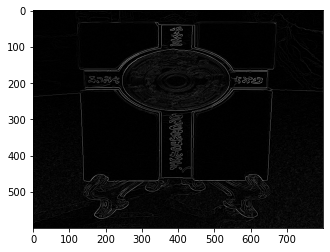

In [8]:
# non-maximal suppression
def non_maximal_suppression(img, theta):
    print('    start Non-maximal suppression')
    
    height = img.shape[0]
    width = img.shape[1]
    non_maximal = img.copy()
    angle = theta * 180.0 / math.pi
    angle[angle<0] += 180
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            G1 = 0
            G2 = 0
            # angle == 0
            if((0 <= angle[i][j] < 22.5) or (157.5 < angle[i][j] <= 180)):
                G1 = img[i][j + 1]
                G2 = img[i][j - 1]
            # angle == 45
            elif(22.5 <= angle[i][j] <= 67.5):
                G1 = img[i + 1][j - 1]
                G2 = img[i - 1][j + 1]
            # angle == 90
            elif(67.5 < angle[i][j] < 112.5):
                G1 = img[i + 1][j]
                G2 = img[i - 1][j]
            # angle == 135
            elif(112.5 <= angle[i][j] <= 157.5):
                G1 = img[i - 1][j - 1]
                G2 = img[i + 1][j + 1]
            
            if(img[i][j] >= G1) and (img[i][j] >= G2):
                non_maximal[i][j] = img[i][j]
            else:
                non_maximal[i][j] = 0
    return non_maximal

non_maximal_sample1 = non_maximal_suppression(gradient_sample1, theta_sample1)
plt.imshow(non_maximal_sample1, cmap='gray')

    start hysteretic thresholding


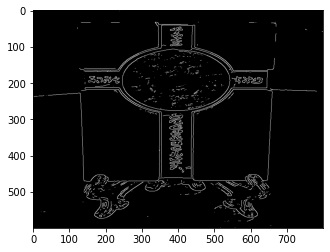

In [9]:
# hysteretic thresholding
def hysteretic_thresholding(img, threshold_H, threshold_L):
    print('    start hysteretic thresholding')
    height = img.shape[0]
    width = img.shape[1]
    thresholding = np.zeros((height, width), dtype = 'uint8')
    for i in range(height):
        for j in range(width):
            if(img[i][j] >= threshold_H):
                thresholding[i][j] = 2
            elif(img[i][j] >= threshold_L):
                thresholding[i][j] = 1
            else:
                thresholding[i][j] = 0
    return thresholding
thresholding_sample1 = hysteretic_thresholding(non_maximal_sample1,60,100)
plt.imshow(thresholding_sample1, cmap='gray')

    start connected component labeling


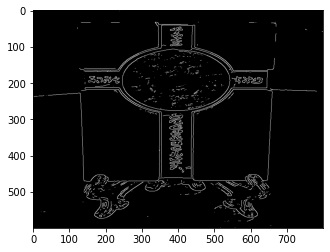

In [10]:
# connected component labeling method
def set_edge_point(img, i, j): #使用遞迴
    height = img.shape[0]
    width = img.shape[1]
    if i<0 or j<0 or i>=height or j>=width : return 0
    
    for k in range(3): 
        for l in range(3):
            if(i + k - 1 >= 0 and i + k - 1 < height and j + l - 1 >= 0 and j + l - 1 < width):
                if(img[i + k - 1][j + l - 1] == 1):
                    img[i][j] = set_edge_point(img, i + k - 1, j + l - 1)
                if(img[i + k - 1][j + l - 1] == 2): return 255
                else: return 0
                
def connected_component_labeling(img):
    print('    start connected component labeling')
    height = img.shape[0]
    width = img.shape[1]
    for i in range(height):
        for j in range(width):
            if(img[i][j] == 2): # edge
                img[i][j] = 255
            elif(img[i][j] == 1): # candidate 
                set_edge_point(img, i, j)
    return img

label_sample1 = connected_component_labeling(thresholding_sample1)
plt.imshow(label_sample1, cmap='gray')

## Laplacian of Gaussian

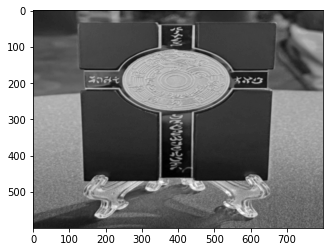

In [11]:
# Gaussian Low-pass Filter
img = sample1.copy()
kernel = np.array([[1, 4, 7, 4, 1], [4, 16, 26, 16, 4], [7, 26, 41, 26, 7], [4, 16, 26, 16, 4], [1, 4, 7, 4, 1]], dtype = 'uint8') / 273
bulr_img = convolve2d(img, kernel)
plt.imshow(bulr_img, cmap='gray')

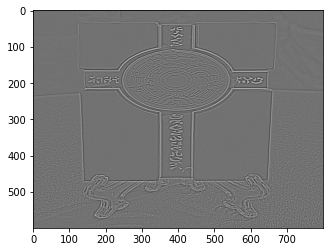

In [12]:
# 2nd-order Derivative (Laplacian)
laplacian_kernel = np.array(
    [[-2,1,-2],
     [1,4,1],
     [-2,1,-2]]
)/8

kernel_size = laplacian_kernel.shape[0]
gap = kernel_size // 2

pad_img = np.lib.pad(bulr_img,(gap,gap),'reflect')
height, width = pad_img.shape
laplacian_img = np.zeros((height, width), dtype = 'float32')

for i in range(gap, height - gap):
    for j in range(gap, width - gap):
        patch = pad_img[i-gap:i+gap+1,j-gap:j+gap+1]
        gradient = laplacian_kernel * patch
        laplacian_img[i][j] = gradient.sum()

laplacian_img = laplacian_img[gap:height-gap,gap:width-gap]
plt.imshow(laplacian_img, cmap='gray')

Text(0.5, 1.0, 'title')

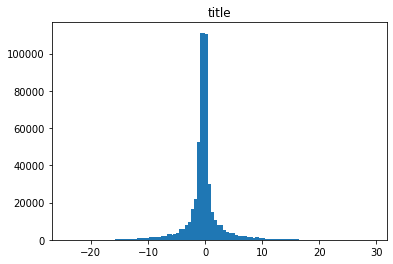

In [13]:
hist,bins = np.histogram(laplacian_img,bins=100,range=(laplacian_img.min(),laplacian_img.max()))
bins = bins[:-1]
plt.bar(bins,hist)
plt.title('title')

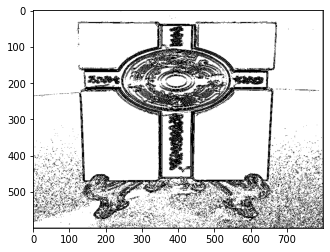

In [14]:
# Thresholded
T = 3
height, width = laplacian_img.shape
threshold_img = np.zeros((height, width))
for i in range(1,height - 1):
    for j in range(1,width - 1):
        if np.abs(laplacian_img[i][j])<=T:
            threshold_img[i][j] = 255
        else: threshold_img[i][j] = 0

plt.imshow(threshold_img, cmap='gray')

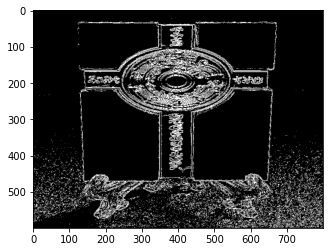

In [15]:
# Zero-crossing
height, width = laplacian_img.shape
res = np.zeros((height, width))
for i in range(1,height - 1):
    for j in range(1,width - 1):
        if threshold_img[i][j] == 0:
            if ( laplacian_img[i-1][j-1]*laplacian_img[i+1][j+1] < 0 or\
               laplacian_img[i-1][j]*laplacian_img[i+1][j] < 0 or\
               laplacian_img[i-1][j+1]*laplacian_img[i+1][j-1] < 0 or\
               laplacian_img[i][j-1]*laplacian_img[i][j+1] < 0):
                res[i][j] = 255
            else: res[i][j] = 0
        else: res[i][j] = 0

plt.imshow(res, cmap='gray')

## edge crispening

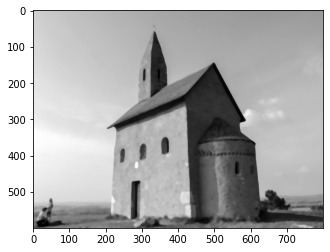

In [16]:
 plt.imshow(sample2, cmap='gray')

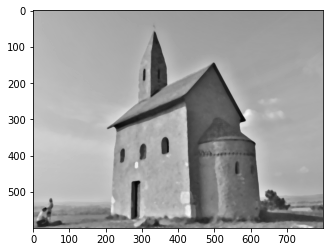

In [17]:
# edge crispening method
def edge_crispening(img, kernel, c):
    LP = convolve2d(img, kernel)
    edge_crispening = (c / (2 * c - 1)) * img - ((1 - c) / (2 * c - 1)) * LP
    plt.imshow(edge_crispening, cmap='gray')
    
edge_crispening(sample2, gauss(77, 25) ,  4 / 6)

## Hough transform

start hough transform


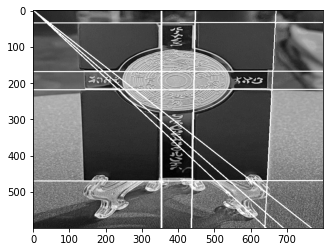

In [42]:
def hough_transform(img, n):
    print('start hough transform')
    # Sobel edge detect
    gradient = sobel_gradient(img)
    edge = sobel_threshold(gradient,200)
    
    # Generate sin and cos look-up table
    sin_tab = np.zeros(180)
    cos_tab = np.zeros(180)

    for angle in range(180):
        theta=angle*3.14159265358979/180.0
        cos_tab[angle]=np.cos(theta)
        sin_tab[angle]=np.sin(theta)
        
    # compute hough_img
    feature_point = 255
    h, w = edge.shape  
    rmax = int(math.hypot(h, w))
    hough_img = np.zeros((180,rmax*2))

    for i in range(h):
        for j in range(w):
            if edge[i][j]==feature_point:
                for angle in range(180):                # for each angle
                    p=i*sin_tab[angle]+j*cos_tab[angle] # compute p
                    p=int(p)                            # shift r to positive value
                    hough_img[angle][p+rmax] += 1       # accumulation
    plt.imshow(hough_img, cmap='gray')
    
    # draw top n line
    a = hough_img.reshape(1,-1)[0]
    index = np.argpartition(a,-n)[-n:]
    for idx in index:
        angle, p = unravel_index(idx, hough_img.shape)
        p -= rmax

        a = sin_tab[angle]
        b = cos_tab[angle]
        
        # 注意除以0的case
        if b < 1e-12:
            x0 = w
            y0 = (p-x0*b)/a

            x1 = 0
            y1 = (p-x1*b)/a
        else:
            y0 = h
            x0 = (p-y0*a)/b

            y1 = 0
            x1 = (p-y1*a)/b

        x0 = int(x0)
        y0 = int(y0)
        x1 = int(x1)
        y1 = int(y1)

        cv2.line(img,(x0,y0),(x1,y1),(255),2)
    plt.imshow(img, cmap='gray')
    
hough_transform(sample1.copy(), 13) # top n max

## improve sample3.png

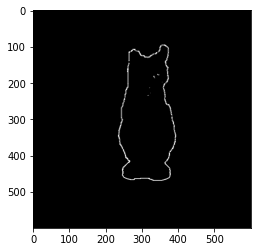

In [19]:
problem2a_edge = sobel_threshold(sobel_gradient(sample3),255)
plt.imshow(problem2a_edge, cmap='gray')

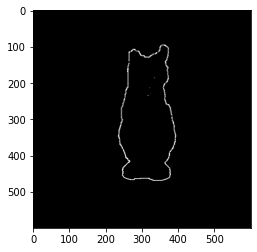

In [20]:
problem2a_edge[170:185,330:370] = 0 # 去掉貓臉
plt.imshow(problem2a_edge, cmap='gray')

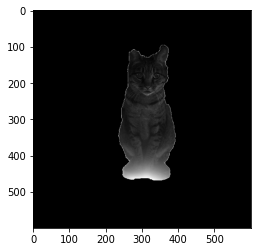

In [21]:
plt.imshow(sample3, cmap='gray')

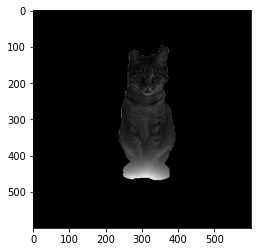

In [22]:
# 去掉白邊
problem2a = sample3.copy()
problem2a[problem2a_edge==255] = 0
plt.imshow(problem2a, cmap='gray')

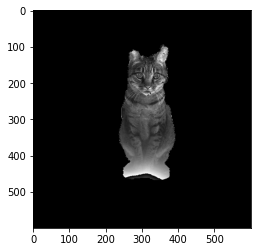

In [23]:
# 降低上半部和下半部的對比
for i in range(problem2a.shape[0]):
    problem2a[i] = problem2a[i]/((i+1)/600)
plt.imshow(problem2a, cmap='gray')

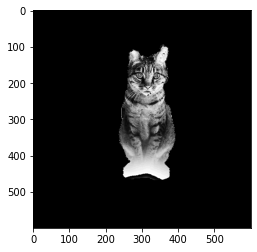

In [24]:
def globalHE(img):
    hist,bins = np.histogram(img.ravel(),256,[0,255])
    pdf = hist/img.size # 出現次數/總像素點 = 機率 = pdf
    cdf = pdf.cumsum() # 將機率利用cumsum()累加 = cdf
    equ_value = np.around(cdf * 255).astype('uint8') #將cdf乘以255(max value) ，再四捨五入取整數
    result = equ_value[img] #將原本的value數值transfer到對應的數值
    return result

plt.imshow(globalHE(problem2a), cmap='gray')

## rotation, scaling, translation

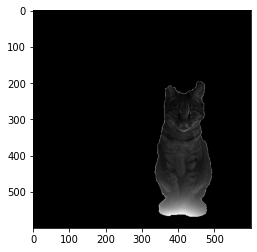

In [25]:
def translate(img,dx,dy):
    img2 = np.zeros(img.shape)
    h,w = img.shape
    for j in range(h):
        for k in range(w):
            u = j + dy
            v = k - dx
            if u<0 or u>=h or v<0 or v>=w: continue
            img2[j][k] = img[u][v]
            
    return img2
plt.imshow(translate(sample3,100,-100), cmap='gray')

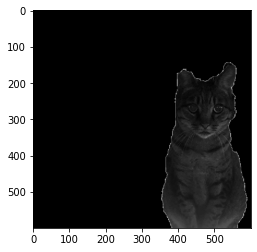

In [26]:
def scale(img,s):
    h,w = img.shape
    img2 = np.zeros((h,w))
    
    for j in range(int(h)):
        for k in range(int(w)):
            u = int(j / s)
            v = int(k / s)
            if u<0 or u>=h or v<0 or v>=w: continue
            img2[j][k] = img[u][v]
            
    return img2


plt.imshow(scale(sample3,1.5), cmap='gray')

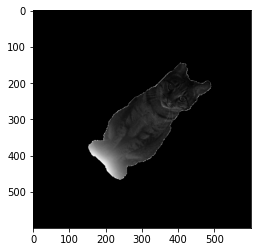

In [27]:
def rotate(img,theta):
    h,w = img.shape
    img2 = np.zeros((h,w))
    middle = h / 2
    c = np.cos(theta*np.pi/180)
    s = np.sin(theta*np.pi/180)
    R = np.array([[c, -s],
                  [s, c]])
    for j in range(h):
        for k in range(w):
            # 先移到中心點再移回來
            coordinate = np.array([float(j-middle), float(k-middle)])
            rotate_point = R.dot(coordinate)
            rotate_point += middle
            u,v=rotate_point
            u = int(u)
            v = int(v)
            if u<0 or u>=h or v<0 or v>=w: continue
            img2[j][k] = img[u][v]
            
    return img2

plt.imshow(rotate(sample3,45), cmap='gray')

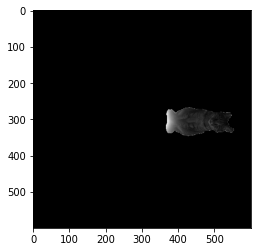

In [28]:
plt.imshow(translate(scale(rotate(sample3,90),1/2),300,-150), cmap='gray')

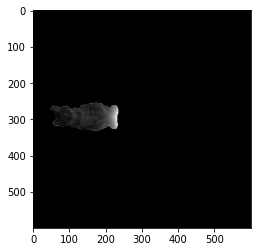

In [29]:
plt.imshow(translate(scale(rotate(sample3,-90),1/2),0,-150), cmap='gray')

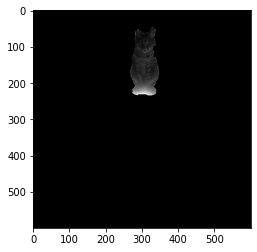

In [30]:
plt.imshow(translate(scale(rotate(sample3,0),1/2),150,0), cmap='gray')

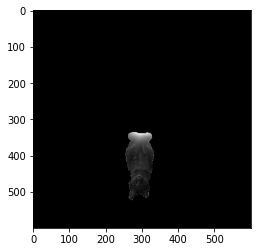

In [51]:
plt.imshow(translate(scale(rotate(sample3,180),1/2),150,-270), cmap='gray')

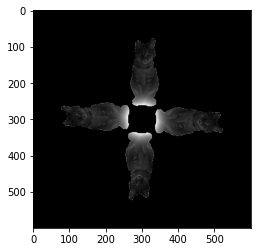

In [52]:
L = translate(scale(rotate(sample3,-90),1/2),30,-150)
R = translate(scale(rotate(sample3,90),1/2),270,-150)
U = translate(scale(rotate(sample3,0),1/2),150,-30)
D = translate(scale(rotate(sample3,180),1/2),150,-270)
plt.imshow(L+R+U+D, cmap='gray')

## liquid cat

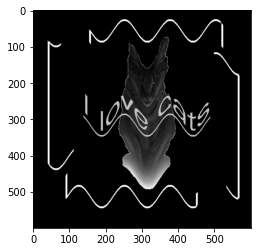

In [33]:
def liquid_cat_verticle(img, wave_length, Wave_crest):
    h,w = img.shape
    img2 = np.zeros((h,w))
    
    for k in range(w):
        shif = np.cos(k/wave_length)*Wave_crest
        for j in range(h):
            u = j + shif
            u = int(u)
            if u<0 or u>=h: continue
            img2[j][k] = img[u][k]
            
    return img2
        
plt.imshow(liquid_cat_verticle(sample5,20,30), cmap='gray')

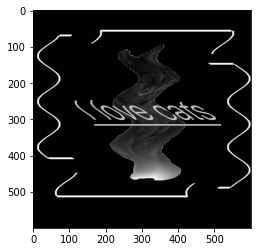

In [34]:
def liquid_cat_horizontal(img, wave_length, Wave_crest):
    h,w = img.shape
    img2 = np.zeros((h,w))
    
    for j in range(h):
        shif = np.cos(j/wave_length)*Wave_crest
        for k in range(w):
            v = k + shif
            v = int(v)
            if v<0 or v>=w: continue
            img2[j][k] = img[j][v]
            
    return img2
        
plt.imshow(liquid_cat_horizontal(sample5,20,30), cmap='gray')

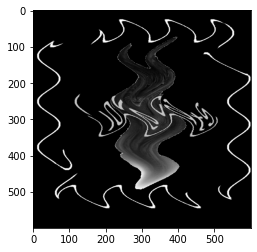

In [35]:
plt.imshow(liquid_cat_horizontal(liquid_cat_verticle(sample5,20,30),20,30), cmap='gray')

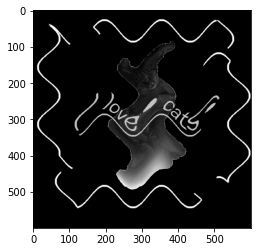

In [36]:
def liquid_cat(img, wave_length, Wave_crest):
    h,w = img.shape
    img2 = np.zeros((h,w))
    
    for j in range(h):
        for k in range(w):
            shif_v = np.cos(j/wave_length)*Wave_crest
            shif_u = np.sin(k/wave_length)*Wave_crest
            u = j + shif_u
            v = k + shif_v
            u = int(u)
            v = int(v)
            if u<0 or u>=h or v<0 or v>=w: continue
            img2[j][k] = img[u][v]
            
    return img2
        
plt.imshow(liquid_cat(sample5,25,30), cmap='gray')

## Hough transform test

In [37]:
# Generate sin and cos look-up table
sin_tab = np.zeros(180)
cos_tab = np.zeros(180)

for angle in range(180):
    theta=angle*3.14159265358979/180.0
    cos_tab[angle]=np.cos(theta)
    sin_tab[angle]=np.sin(theta)

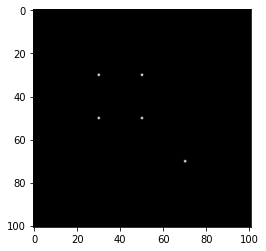

In [38]:
img = np.zeros((101,101))
# (y, x)
img[30,30] = 255  
img[50,30] = 255
img[50,50] = 255
img[70,70] = 255
img[30,50] = 255

plt.imshow(img, cmap='gray')


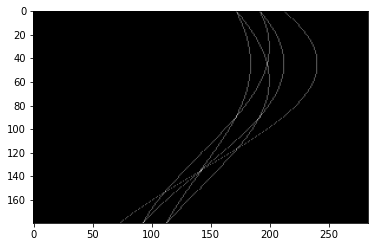

In [39]:
feature_point = 255
h, w = img.shape  
rmax = int(math.hypot(h, w))
hough_ima = np.zeros((180,rmax*2))

for i in range(h):
    for j in range(w):
        if img[i][j]==feature_point:
            for angle in range(180):  # for each theta
                p=i*sin_tab[angle]+j*cos_tab[angle] # compute r
                p=int(p)                     # shift r to positive value
                hough_ima[angle][p+rmax] += 1           # accumulation

plt.imshow(hough_ima, cmap='gray')

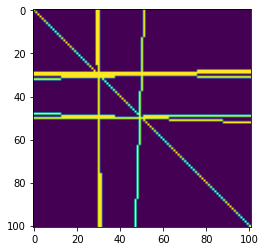

In [40]:
img2 = img.copy()

a = hough_ima.reshape(1,-1)[0]
n = 10
index = np.argpartition(a,-n)[-n:]
for idx in index:
    angle, p = unravel_index(idx, hough_ima.shape)
    p -= rmax
    
    a = sin_tab[angle]
    b = cos_tab[angle]
    
    if b < 1e-12:
        x0 = 600
        y0 = (p-x0*b)/a

        x1 = 0
        y1 = (p-x1*b)/a
    else:
        y0 = 600
        x0 = (p-y0*a)/b

        y1 = 0
        x1 = (p-y1*a)/b

    x0 = int(x0)
    y0 = int(y0)
    x1 = int(x1)
    y1 = int(y1)
    
    cv2.line(img2,(x0,y0),(x1,y1),(50),1)

plt.imshow(img2)